# Where should I place a hotel to give tourists access to most points of information?

In [2]:
%matplotlib inline
import sys
sys.path.insert(1,'../Utilities')
# notebook
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
from math import sin, cos, sqrt, atan2, radians,pi
from utils import *
from data import listedEiggHotels, pointsOfInterest
import json
#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [3]:
def graphTwoSetsByObservations(buildingLocs,obsLocs,dist=500):
    distance_away = dist

    G = nx.Graph()

    colorMap = (['gold'] * len(buildingLocs)) + (['blue'] * len(obsLocs))

    for k,r in enumerate(buildingLocs):
        G.add_node(k, color="green")

    for k,o in enumerate(obsLocs):
        G.add_node(k+len(buildingLocs), color="blue")

    for o_index,o in enumerate(obsLocs):
        for r_index,r in enumerate(buildingLocs):
            if seperationInMetres(o,r) < distance_away:
                G.add_edge(o_index+len(buildingLocs),r_index)
                
    return G, colorMap

def getIsolatesAtOffset(G,offset):
    degrees = G.degree()
    degreesOfInterest = filter(lambda x: x[1] == 0,degrees)
    degreesOfInterest = filter(lambda x: x[0] > offset, degreesOfInterest)
    nodeIds = map(lambda x: x[0],degreesOfInterest)
    
    return list(nodeIds)

def getBoundingBox(latLons):
    lats = list(map(lambda x: x[0],latLons))
    lons = list(map(lambda x: x[1],latLons))
        
    return [[min(lats),max(lats)],[min(lons),max(lons)]]

def addPseudoHotel(lat,lon):
    hotels = listedEiggHotels()
    hotels[",".join([str(lat),str(lon)])] = "Pseudo"
    
    return hotels

interests = toUsableLatLonList(pointsOfInterest().keys())
hotels = toUsableLatLonList(listedEiggHotels().keys())

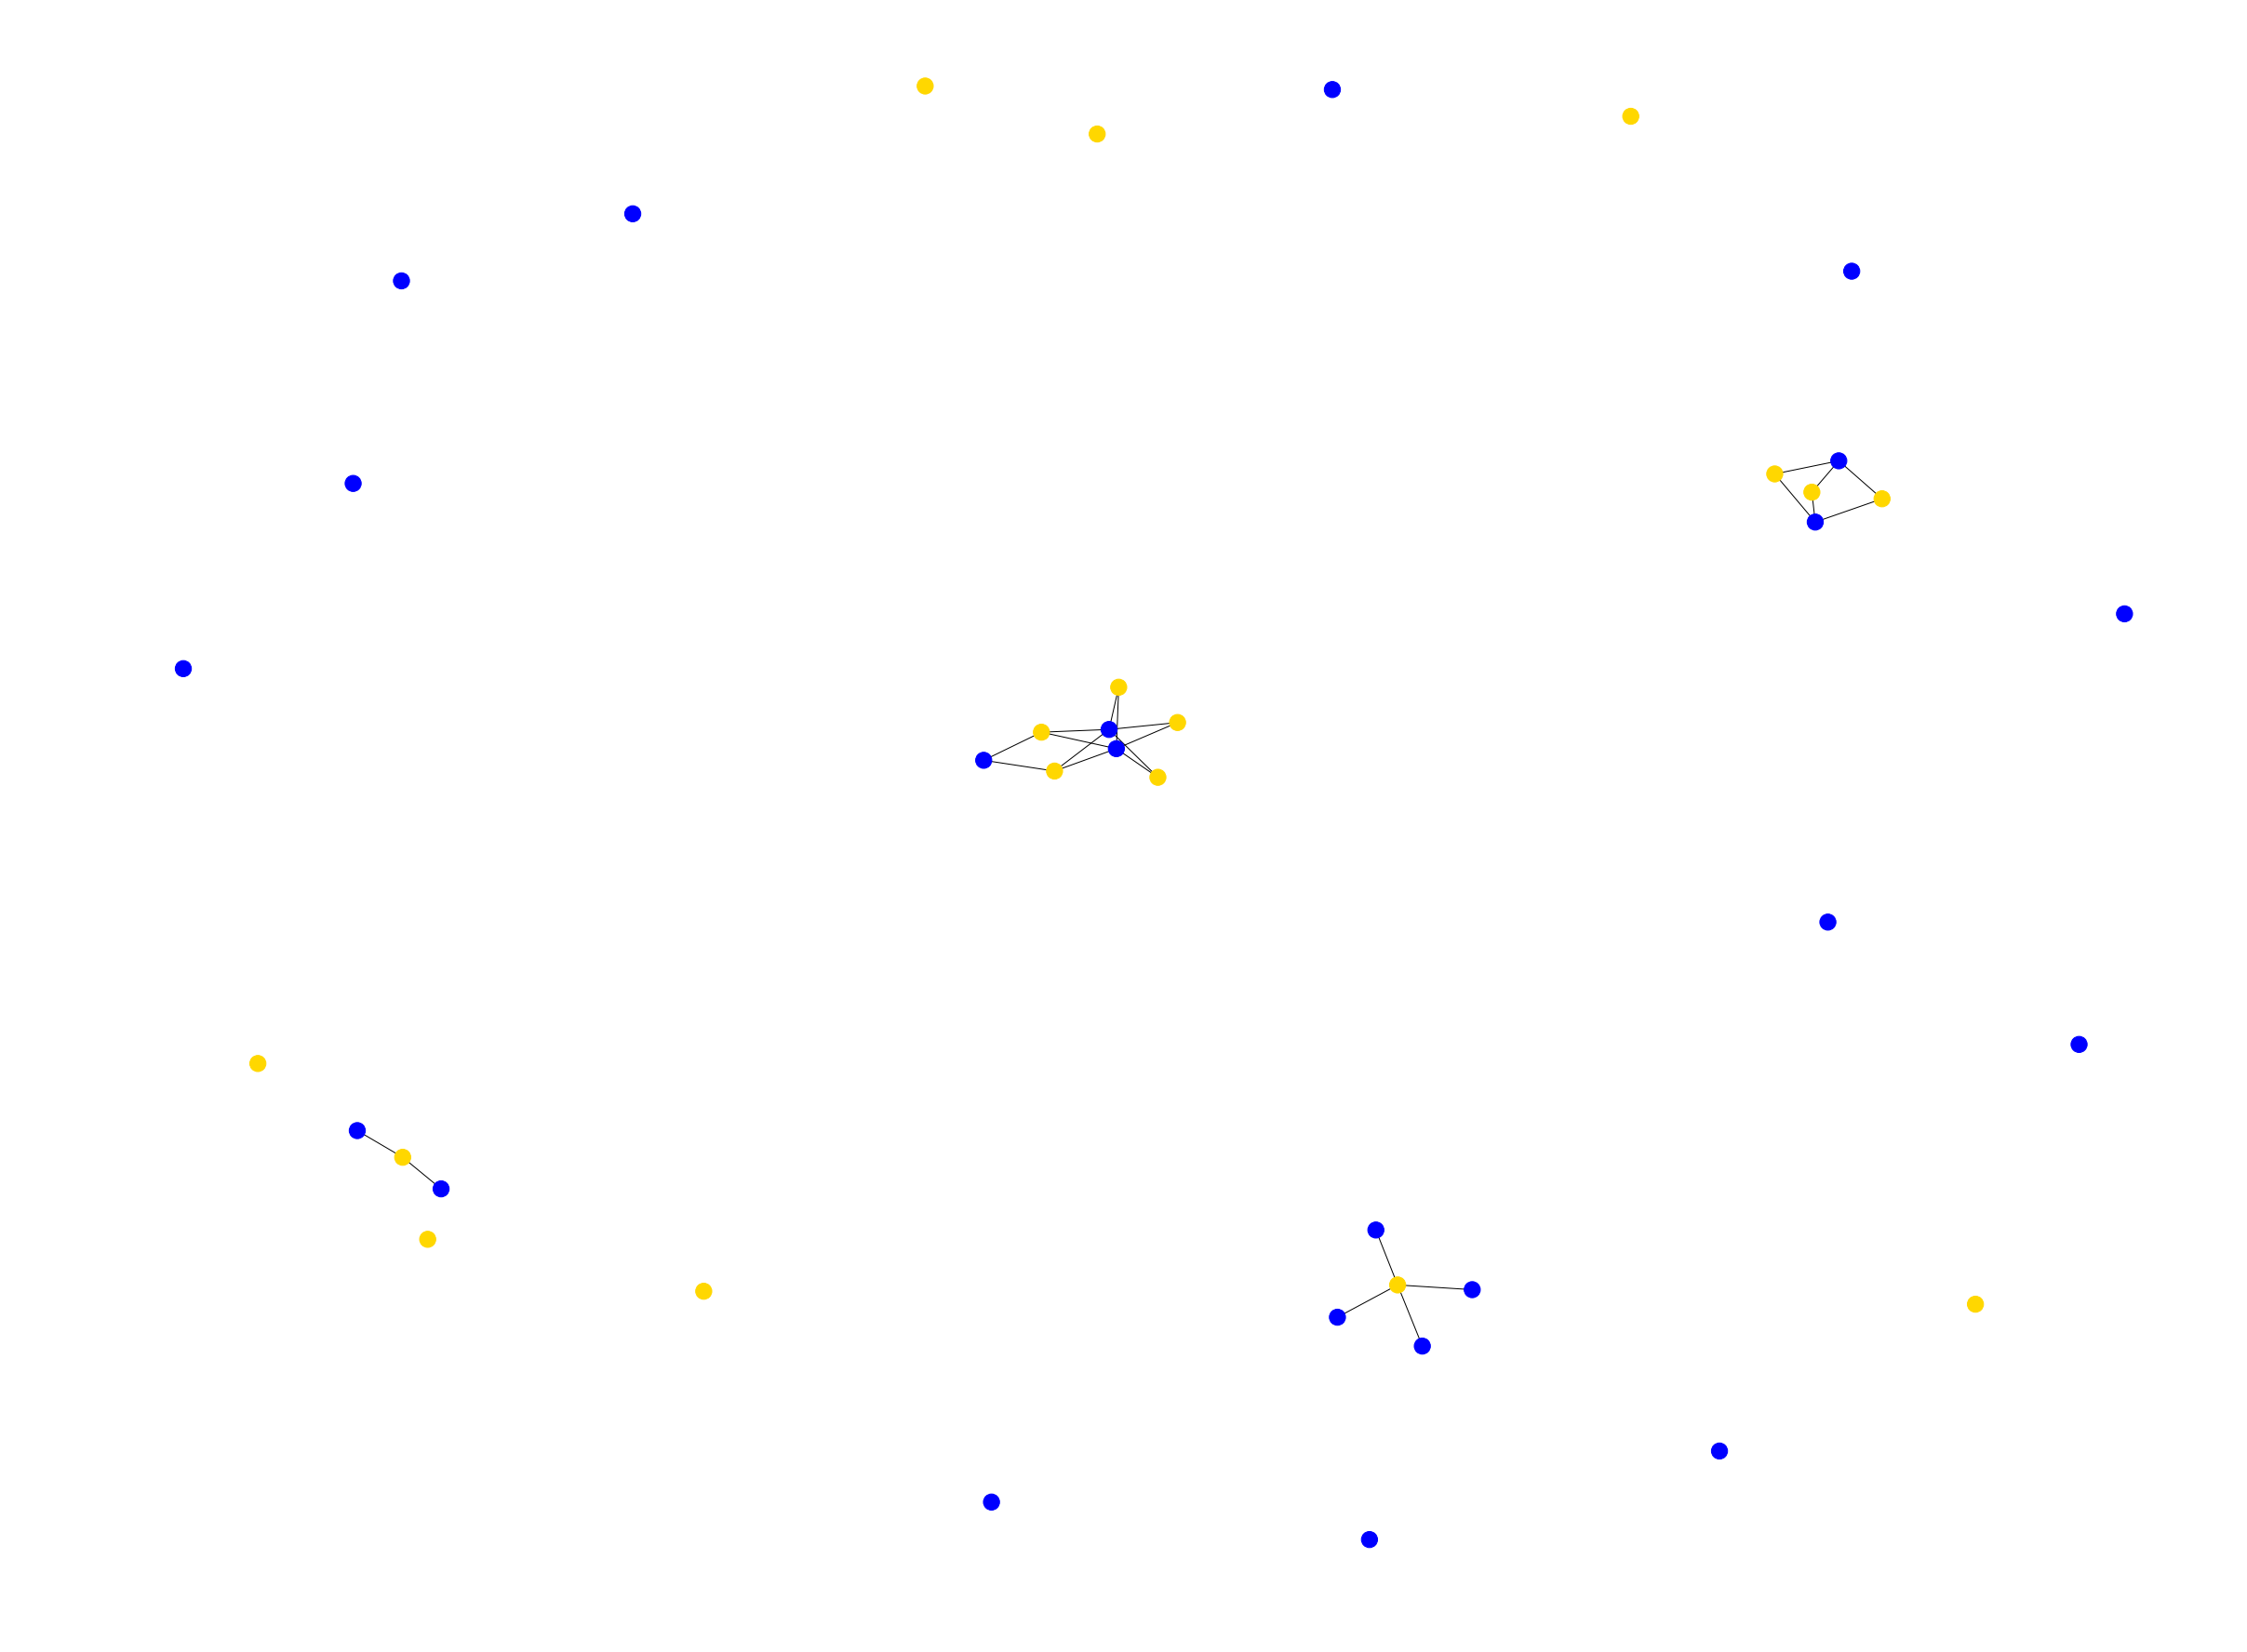

In [4]:
Goi, colorMap = graphTwoSetsByObservations(hotels,interests)
nx.draw(Goi, node_color=colorMap)

In [5]:
len(getIsolatesAtOffset(Goi,len(hotels)-1))

12

In [6]:
[minLat,maxLat],[minLon,maxLon] = getBoundingBox(hotels+interests)
optimals = []

horizontalMetres = seperationInMetres((minLat,minLon),(minLat,maxLon))
verticalMetres = seperationInMetres((minLat,minLon),(maxLat,minLon))

print(horizontalMetres,verticalMetres)

currentIsolates = len(getIsolatesAtOffset(Goi,len(hotels)-1))

currLatOffset = 0
currLonOffset = 0

while currLonOffset+100 < horizontalMetres:
    while abs(currLatOffset)+100 < verticalMetres:
        newLat, newLon = transformLatLonByXMetres(maxLat,minLon,currLatOffset,currLonOffset)
        newHotels = toUsableLatLonList(addPseudoHotel(newLat,newLon).keys())
        
        Goi, colorMap = graphTwoSetsByObservations(newHotels,interests)
        if(len(getIsolatesAtOffset(Goi,len(newHotels)-1)) < currentIsolates):
            currentIsolates = len(getIsolatesAtOffset(Goi,len(newHotels)-1))
            optimals = [newLat,newLon]
        
        currLatOffset -= 100
    
    currLonOffset += 100
    currLatOffset = 0
    
optimals

4246.8483262713735 6401.543853962734


[56.88293445107814, -6.173117083739027]

In [7]:
interests = toUsableLatLonList(pointsOfInterest().keys())
hotels = toUsableLatLonList(listedEiggHotels().keys())
Goi, colorMap = graphTwoSetsByObservations(hotels,interests)

generateMapJSON([('./fullColMarkers/marker76.png',hotels),('./fullColMarkers/marker2.png',interests),('./fullColMarkers/marker18.png',[[56.882495621816346,-6.172800731120484]])],[(hotels+interests,Goi)],"testingNewHotel.txt")


# ALT; consider all points (as a score) 

In [8]:
def scorePseudoHotel(lat,lon,interests):
    score = 0
    for interest in interests:
        score += seperationInMetres((lat,lon),interest)
    return score

[minLat,maxLat],[minLon,maxLon] = getBoundingBox(hotels+interests)
optimals = []

horizontalMetres = seperationInMetres((minLat,minLon),(minLat,maxLon))
verticalMetres = seperationInMetres((minLat,minLon),(maxLat,minLon))

currentScore = 1000000000
currLatOffset = 0
currLonOffset = 0

Goi, colorMap = graphTwoSetsByObservations(hotels,interests)
firstBlue = colorMap.index('blue')

print(maxLat,minLon)
while currLonOffset+100 < horizontalMetres:
    while abs(currLatOffset)+100 < verticalMetres:
        newLat, newLon = transformLatLonByXMetres(maxLat,minLon,currLatOffset,currLonOffset)
        unmappedInterests = list(filter(lambda x: x[1] == 0 and x[0] >= firstBlue,Goi.degree))
        unmappedInterests = list(map(lambda x: x[0] - len(hotels), unmappedInterests))
        interestOnlyEdges = [interests[i] for i in unmappedInterests]

        scoreCurrentHotelPosition = scorePseudoHotel(newLat,newLon,interestOnlyEdges)
        if(scoreCurrentHotelPosition < currentScore):
            currentScore = scoreCurrentHotelPosition
            optimals = [newLat,newLon]

        currLatOffset -= 100
    
    currLonOffset += 100
    currLatOffset = 0
    
optimals

56.9269519 -6.1912247


[56.88742602749874, -6.1566556144108695]

In [9]:
interests = toUsableLatLonList(pointsOfInterest().keys())
hotels = toUsableLatLonList(listedEiggHotels().keys())
Goi, colorMap = graphTwoSetsByObservations(hotels,interests)

generateMapJSON([('./fullColMarkers/marker76.png',hotels),('./fullColMarkers/marker2.png',interests),('./fullColMarkers/marker18.png',[[56.88742602749874, -6.1566556144108695]])],[(hotels+interests,Goi)],"allLocationsHotel.txt")